In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import cv2

import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T

In [2]:
def overlay_transparent(background, overlay, x, y):
    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

def put_on_glass(img, glass_dir, left_eye_point, right_eye_point):
    glass = cv2.imread(glass_dir, cv2.IMREAD_UNCHANGED)
    x1, y1 = left_eye_point
    x2, y2 = right_eye_point

    x = (x1 + x2) // 2
    y = (y1 + y2) // 2

    # rotate glass
    radian = math.atan2(y2-y1, x2-x1)
    degree = 360 - math.degrees(radian)

    glass_center = tuple(map(lambda x: x//2, glass.shape[:2]))
    M = cv2.getRotationMatrix2D(glass_center, degree, 1)

    # rescale glass
    resize_scale = int((x2-x1)*2) 
    rotate_glass = cv2.warpAffine(glass, M, glass.shape[:2])

    rotate_glass = cv2.resize(rotate_glass, (resize_scale, resize_scale))
    overay_img = overlay_transparent(img, rotate_glass, x-(resize_scale//2), y-(resize_scale//2))
    return overay_img

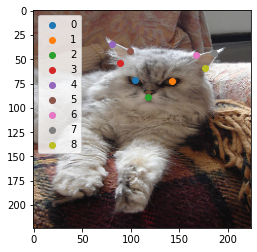

In [3]:
data_dir = "/content/drive/My Drive/Colab Notebooks/cat_data"
data = []
with open(f"{data_dir}/resized_CAT_00_0.pkl", "rb") as f:
    cat_dict = pickle.load(f)
    
img = cat_dict["data"][0]
point = cat_dict["label"][0]
plt.imshow(img)
for i in range(9):
    plt.scatter(point[i,0], point[i,1], color=f"C{i}", label=i)
plt.legend()

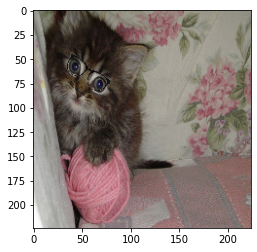

In [4]:
img = cat_dict["data"][1]
point = cat_dict["label"][1]
glass_dir = "/content/drive/My Drive/Colab Notebooks/glasses.png"
overlay_img = put_on_glass(img, glass_dir, point[0], point[1])
plt.imshow(overlay_img)

# Data

In [5]:
class CatDataset(Dataset):
    def __init__(self, imgs, points, transform):
        super().__init__()
        self.imgs = imgs
        self.points = points
        self.transform = transform

    def __getitem__(self, idx):
        img = self.transform(self.imgs[idx])
        point = self.points[idx]
        return img, point

    def __len__(self):
        return self.imgs.shape[0]

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_loader = DataLoader(CatDataset(cat_dict["data"], cat_dict["label"], transform), batch_size=32, shuffle=True)

# Model

In [8]:
class CatFaceDetection(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.features = model.features
        self.last_layer = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(62720, 18)
        )

    def forward(self, x):
        batch_size, *_ = x.size()
        features = self.features(x)
        output = self.last_layer(features.view(batch_size, -1))
        return output

In [9]:
mobile_net = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
face_model = CatFaceDetection(mobile_net)
_ = face_model.cuda()
optimizer = torch.optim.Adam(face_model.parameters())

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


# Train

In [10]:
train_history = []
for epoch in range(30):
    face_model.train()
    train_loss = 0
    for img, point in train_loader:
        optimizer.zero_grad()
        output = face_model(img.cuda())
        point = torch.IntTensor(point)
        mse_loss = nn.MSELoss()
        loss = mse_loss(point.view(-1, 18).cuda(), output)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_history += [train_loss]

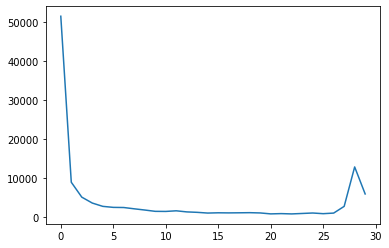

In [11]:
plt.plot(train_history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


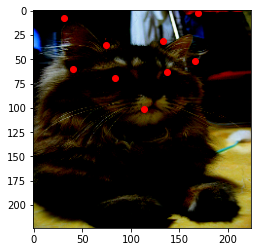

In [24]:
imgs = []
points = []
with torch.no_grad():
    face_model.eval()
    for img, point in train_loader:
        output = face_model(img.cuda())
        break

output = output.cpu().numpy().reshape(-1, 9, 2)
plt.imshow(img[0].permute(1,2,0).numpy())
plt.scatter(output[0,:,0], output[0,:,1], color="red")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


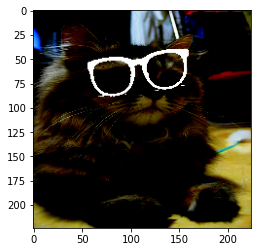

In [29]:
cat_img = img[0].permute(1,2,0).numpy()
cat_point = output[0]
overlay_img = put_on_glass(cat_img, glass_dir, cat_point[0].astype(int), cat_point[1].astype(int))
plt.imshow(overlay_img)